# Diabetes Prediction (Supervised ML)

End-to-end supervised ML workflow:
data loading → quick checks → baseline models → hyperparameter tuning (SVM) → evaluation → model saving.


In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns 

from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

from sklearn.pipeline import Pipeline

from sklearn.model_selection import cross_val_score, KFold, GridSearchCV, train_test_split
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, ConfusionMatrixDisplay


#1 Data Loading


In [2]:
diabetes_df = pd.read_csv("data\Training.csv")

diabetes_df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


#2 Data Inspection
- shape, info, summary statistics
- missing values check


In [3]:
diabetes_df.shape

(2460, 9)

In [4]:
diabetes_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2460 entries, 0 to 2459
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               2460 non-null   int64  
 1   Glucose                   2460 non-null   int64  
 2   BloodPressure             2460 non-null   int64  
 3   SkinThickness             2460 non-null   int64  
 4   Insulin                   2460 non-null   int64  
 5   BMI                       2460 non-null   float64
 6   DiabetesPedigreeFunction  2460 non-null   float64
 7   Age                       2460 non-null   int64  
 8   Outcome                   2460 non-null   int64  
dtypes: float64(2), int64(7)
memory usage: 173.1 KB


In [5]:
diabetes_df.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,2460.000000,2460.000000,2460.000000,2460.000000,2460.000000,2460.000000,2460.000000,2460.000000,2460.000000
mean,3.817480,121.602033,68.915041,20.531301,80.119919,31.990447,0.491440,32.821951,0.390244
std,3.296458,31.789270,19.082655,15.716901,116.765807,7.802569,0.363917,11.251208,0.487904
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000,0.000000
25%,1.000000,100.000000,64.000000,0.000000,0.000000,27.100000,0.251750,24.000000,0.000000
50%,3.000000,117.000000,70.000000,23.000000,36.000000,32.100000,0.381000,29.000000,0.000000
75%,6.000000,142.000000,80.000000,33.000000,129.000000,36.500000,0.647000,39.000000,1.000000
max,17.000000,197.000000,122.000000,63.000000,846.000000,67.100000,2.420000,81.000000,1.000000


In [6]:
diabetes_df.isna().sum()

Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
Outcome                     0
dtype: int64

#3 Quick EDA
Correlation heatmap for numeric features (high-level view only).


<Axes: >

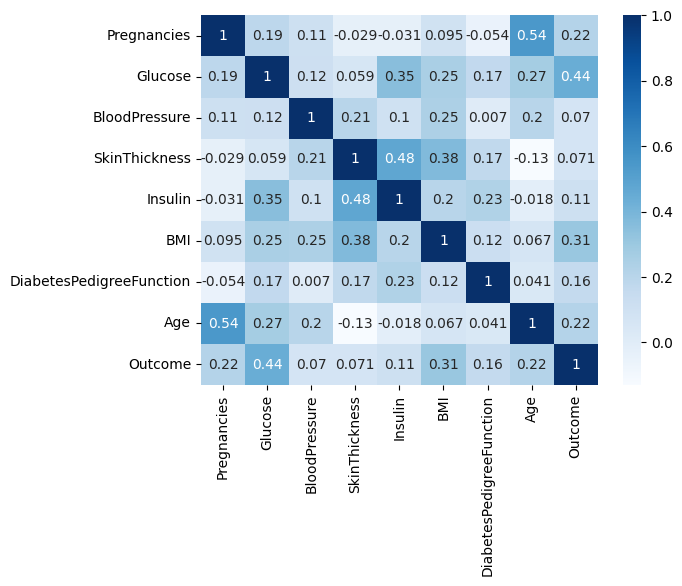

In [7]:
sns.heatmap(diabetes_df.corr(numeric_only = True), annot = True, cmap = "Blues")

#4 Train/Test Split + Baseline Models
Train multiple baseline models to establish a reference performance.


In [8]:
X = diabetes_df.drop(["Outcome"], axis=1)
y = diabetes_df["Outcome"]


X.columns

Index(['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin',
       'BMI', 'DiabetesPedigreeFunction', 'Age'],
      dtype='object')

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

models = {"Logistic Regression": LogisticRegression(max_iter = 1000),
          "Support Vector Machine": SVC()}

results = []

for name, model in models.items():
    model.fit(X_train, y_train)

    train_score = model.score(X_train, y_train)
    test_score = model.score(X_test, y_test)

    results.append((name, train_score, test_score))

    print(f"{name}")
    print(f"Train Accuracy: {train_score:.4f}")
    print(f"Test  Accuracy: {test_score:.4f}")
    print("-" * 30)

Logistic Regression
Train Accuracy: 0.7459
Test  Accuracy: 0.7297
------------------------------
Support Vector Machine
Train Accuracy: 0.7480
Test  Accuracy: 0.7317
------------------------------


#5 Hyperparameter Tuning (SVM + Pipeline)
Using Pipeline to avoid leakage and GridSearchCV to tune hyperparameters.


In [10]:

pipe = Pipeline([
    ("scaler", StandardScaler()),
    ("svm", SVC())
])

param_grid = {
    "svm__C": [0.1, 1, 10, 100],
    "svm__gamma": [1, 0.1, 0.01, 0.001],
    "svm__kernel": ["rbf", "linear"]
}

kf = KFold(n_splits=5, shuffle=True, random_state=42)

grid_search = GridSearchCV(
    pipe,
    param_grid=param_grid,
    cv=kf,
    scoring="accuracy",
    n_jobs=-1
)

grid_result = grid_search.fit(X_train, y_train)

print("Best:", grid_result.best_score_, grid_result.best_params_)


Best: 0.9893336433267459 {'svm__C': 10, 'svm__gamma': 1, 'svm__kernel': 'rbf'}


In [11]:
# Get the best trained pipeline
best_model = grid_result.best_estimator_

# Evaluate
train_acc = best_model.score(X_train, y_train)
test_acc  = best_model.score(X_test, y_test)

print(f"Support Vector Machine \n Train: {train_acc:.4f} | Test: {test_acc:.4f}")



Support Vector Machine 
 Train: 1.0000 | Test: 0.9980


#6 Evaluation
Confusion matrix + classification report on the test set.


In [12]:
y_test_pred = best_model.predict(X_test)

print(confusion_matrix(y_test, y_test_pred))
print(classification_report(y_test, y_test_pred))

[[305   0]
 [  1 186]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       305
           1       1.00      0.99      1.00       187

    accuracy                           1.00       492
   macro avg       1.00      1.00      1.00       492
weighted avg       1.00      1.00      1.00       492



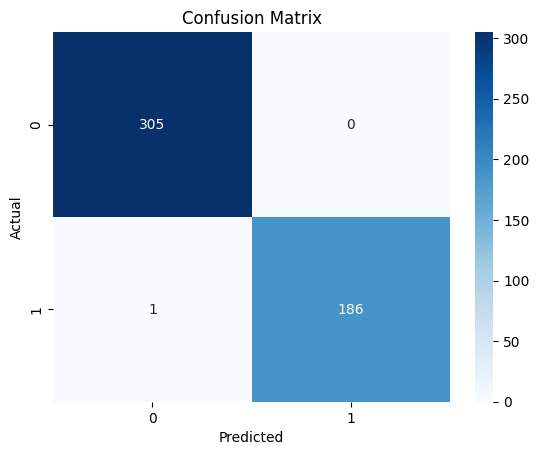

In [13]:
cm = confusion_matrix(y_test, y_test_pred)

sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

#7 Save Model
Save the best trained pipeline for reuse and deployment.


In [17]:
import os
import joblib

# Ensure models folder exists inside the project
os.makedirs("models", exist_ok=True)

# Save the trained model
joblib.dump(best_model, "models/diabetes_best_model.pkl")

print("Model saved in project models folder")


Model saved in project models folder
